In [1]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import BlipProcessor, BlipForConditionalGeneration, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset, DatasetDict, load_from_disk, concatenate_datasets
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt


KeyboardInterrupt



In [2]:
class ROCODataLoader:
    def __init__(self, image_dir_train, image_dir_val, annotation_file_train, annotation_file_val):
        """
        Initializes the data loader with directories for training and validation images, and annotation files.
        :param image_dir_train: Directory where training images are stored.
        :param image_dir_val: Directory where validation images are stored.
        :param annotation_file_train: Path to the CSV file for training annotations.
        :param annotation_file_val: Path to the CSV file for validation annotations.
        """
        self.image_dir_train = image_dir_train
        self.image_dir_val = image_dir_val
        self.annotation_file_train = annotation_file_train
        self.annotation_file_val = annotation_file_val

    def load_data(self):
        """
        Loads and prepares both the training and validation datasets.
        :return: A DatasetDict with 'train' and 'validation' datasets.
        """
        train_df = pd.read_csv(self.annotation_file_train)
        val_df = pd.read_csv(self.annotation_file_val)

        # Add full image paths for training and validation sets
        train_df['image_path'] = train_df['ID'].apply(lambda x: os.path.join(self.image_dir_train, x + ".jpg"))
        val_df['image_path'] = val_df['ID'].apply(lambda x: os.path.join(self.image_dir_val, x + ".jpg"))

        # Convert to Hugging Face dataset format
        train_dataset = Dataset.from_pandas(train_df)
        val_dataset = Dataset.from_pandas(val_df)

        # Return a DatasetDict containing both training and validation sets
        return DatasetDict({'train': train_dataset, 'validation': val_dataset})

In [3]:
class BLIPDataCollator:
    def __init__(self, processor, padding=True):
        self.processor = processor
        self.padding = padding

    def __call__(self, features):
        # Extract text inputs (input_ids) and pixel values (images) separately
        text_inputs = [feature['input_ids'] for feature in features]
        labels = [feature['input_ids'] for feature in features]  # Use input_ids as labels
        
        # Ensure pixel_values are tensors before stacking
        pixel_values = [torch.tensor(feature['pixel_values']) if not isinstance(feature['pixel_values'], torch.Tensor) 
                        else feature['pixel_values'] for feature in features]

        pixel_values = torch.stack(pixel_values)

        # Pad the text inputs and labels
        text_inputs = self.processor.tokenizer.pad(
            {'input_ids': text_inputs},
            padding=self.padding,
            return_tensors="pt"
        )
        labels = self.processor.tokenizer.pad(
            {'input_ids': labels},
            padding=self.padding,
            return_tensors="pt"
        )

        # Return the padded text, the pixel values, and the labels as a dictionary
        return {
            'input_ids': text_inputs['input_ids'],
            'attention_mask': text_inputs['attention_mask'],
            'pixel_values': pixel_values,
            'labels': labels['input_ids']  # Add labels for loss computation
        }


In [4]:
def preprocess_data(examples, processor):
    # Define the transformation pipeline (resize and convert to tensor)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to 224x224
        transforms.ToTensor(),  # Convert to tensor, normalizes pixel values between 0 and 1
    ])

    # Apply transformations to the images
    images = []
    for path in examples['image_path']:
        try:
            img = Image.open(path).convert("RGB")
            img = transform(img)  # Apply transformation
            images.append(img)
        except Exception as e:
            print(f"Error loading image {path}: {e}")
            continue

    # Stack the images into a batch and keep them on CPU initially
    images = torch.stack(images)

    # Process images separately using the processor, and set `do_rescale=False`
    image_inputs = processor(images=images, return_tensors="pt", do_rescale=False)  # Disable rescaling

    # Tokenize text
    text = [caption for caption in examples['Caption']]
    text_inputs = processor.tokenizer(text=text, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Move the input tensors to GPU only after pinning (CPU tensors pinned first, then moved to GPU)
    return {
        'input_ids': text_inputs['input_ids'].to("cuda" if torch.cuda.is_available() else "cpu"),
        'attention_mask': text_inputs['attention_mask'].to("cuda" if torch.cuda.is_available() else "cpu"),
        'pixel_values': image_inputs['pixel_values'].to("cuda" if torch.cuda.is_available() else "cpu")
    }


In [8]:
class BLIPFineTuner:
    def __init__(self, model_name="Salesforce/blip-image-captioning-base", output_dir="./results"):
        self.processor = BlipProcessor.from_pretrained(model_name)
        self.output_dir = output_dir
        self.model_name = model_name
        self.model = None
        self.checkpoint_dir = "./checkpoints"
        os.makedirs(self.checkpoint_dir, exist_ok=True)

    def save_checkpoint(self, epoch, optimizer, scheduler):
        """Save model and optimizer state after each epoch."""
        checkpoint_path = os.path.join(self.checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None
        }, checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}")

    def load_checkpoint(self, optimizer=None, scheduler=None):
        """Load model from the latest checkpoint."""
        checkpoints = [f for f in os.listdir(self.checkpoint_dir) if f.startswith("checkpoint")]
        if checkpoints:
            latest_checkpoint = max(checkpoints, key=lambda x: int(x.split("_")[2].split(".")[0]))
            checkpoint_path = os.path.join(self.checkpoint_dir, latest_checkpoint)
            print(f"Loading checkpoint {checkpoint_path}...")
            checkpoint = torch.load(checkpoint_path)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            if optimizer:
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            if scheduler and 'scheduler_state_dict' in checkpoint:
                scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            start_epoch = checkpoint['epoch'] + 1
            print(f"Resuming from epoch {start_epoch}")
            return start_epoch
        return 0

    def process_in_chunks(self, dataset, chunk_size, dataset_type):
        processed_chunk_dir = f"./processed_{dataset_type}_chunks/"
        if os.path.exists(processed_chunk_dir):
            print(f"Loading preprocessed {dataset_type} chunks from disk...")

            # Gather all chunk folders and load each of them
            chunk_folders = [os.path.join(processed_chunk_dir, folder) for folder in os.listdir(processed_chunk_dir)]
            chunk_datasets = []

            for folder in chunk_folders:
                try:
                    chunk_datasets.append(load_from_disk(folder))
                except Exception as e:
                    print(f"Error loading chunk from {folder}: {e}")
            
            # Concatenate all chunk datasets into a single dataset
            print(f"Concatenating {len(chunk_datasets)} chunks into a single dataset...")
            if len(chunk_datasets) > 0:
                full_dataset = concatenate_datasets(chunk_datasets)
                print(f"Successfully loaded and concatenated {dataset_type} dataset.")
                return full_dataset
            else:
                raise FileNotFoundError(f"No valid chunks found in {processed_chunk_dir}")
        else:
            print(f"No preprocessed {dataset_type} data found. Processing now...")

            # Create a directory for processed chunks if it doesn't exist
            os.makedirs(processed_chunk_dir, exist_ok=True)

            # Process and save each chunk directly to disk to avoid memory exhaustion
            for start_idx in range(0, len(dataset), chunk_size):
                end_idx = min(start_idx + chunk_size, len(dataset))
                chunk = dataset.select(range(start_idx, end_idx))
                print(f"Processing {dataset_type} chunk from {start_idx} to {end_idx}...")
                processed_chunk = chunk.map(lambda examples: preprocess_data(examples, self.processor), 
                                            batched=True, batch_size=1, load_from_cache_file=False)

                # Save the chunk immediately to disk using save_to_disk()
                chunk_path = f"{processed_chunk_dir}/chunk_{start_idx}_{end_idx}"
                print(f"Saving {dataset_type} processed chunk from {start_idx} to {end_idx} at {chunk_path}...")
                processed_chunk.save_to_disk(chunk_path)

            # Reload the chunks after processing
            return self.process_in_chunks(dataset, chunk_size, dataset_type)

    def fine_tune(self, dataset, num_train_epochs=3, batch_size=4, chunk_size=3000):
        if self.model is None:
            print(f"Loading model {self.model_name}...")
            self.model = BlipForConditionalGeneration.from_pretrained(self.model_name)

        device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {device}")
        self.model.to(device)

        # Optimizer and scheduler setup
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=5e-5)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

        # Load checkpoint if exists
        start_epoch = self.load_checkpoint(optimizer=optimizer, scheduler=scheduler)

        # Process or load the dataset in chunks to prevent memory overflow
        print("Processing or loading training set in chunks...")
        processed_train_dataset = self.process_in_chunks(dataset["train"], chunk_size, dataset_type="train")
        print("Processing or loading validation set in chunks...")
        processed_validation_dataset = self.process_in_chunks(dataset["validation"], chunk_size, dataset_type="validation")

        # Use the custom BLIP data collator to handle padding
        data_collator = BLIPDataCollator(self.processor)

        # Set up DataLoaders manually to ensure pin_memory is disabled
        train_dataloader = DataLoader(
            processed_train_dataset,
            batch_size=batch_size,
            shuffle=True,
            pin_memory=False  # Disable pinning to avoid issues
        )

        validation_dataloader = DataLoader(
            processed_validation_dataset,
            batch_size=batch_size,
            shuffle=False,
            pin_memory=False  # Disable pinning
        )

        # Define training arguments with caching
        training_args = TrainingArguments(
            output_dir=self.output_dir,
            eval_strategy="steps",
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=num_train_epochs,
            save_steps=6000,
            save_total_limit=2,
            logging_dir="./logs",
            learning_rate=5e-5,
            logging_steps=500,
            eval_steps=3000,
            remove_unused_columns=False,
            load_best_model_at_end=True,
            gradient_accumulation_steps=8,
            fp16=True,  # Enable mixed precision
            dataloader_num_workers=0,  # Disable parallel loading
            report_to="none"  # Disable W&B or other reporting
        )

        # Initialize Trainer with manually defined DataLoaders
        print("Initializing Trainer...")
        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=processed_train_dataset,
            eval_dataset=processed_validation_dataset,
            data_collator=data_collator,
            optimizers=(optimizer, scheduler),
        )

        # Start training
        print(f"Starting training from epoch {start_epoch}/{num_train_epochs}")
        torch.cuda.empty_cache()

        for epoch in range(start_epoch, num_train_epochs):
            print(f"Training epoch {epoch}/{num_train_epochs}")
            trainer.train()

            # Save checkpoint after each epoch
            self.save_checkpoint(epoch, optimizer, scheduler)
            print(f"Checkpoint saved for epoch {epoch}")

        # Save the final fine-tuned model
        self.save_model()
        print(f"Model saved at {self.output_dir}")
    
    def save_model(self):
        if self.model:
            print("Saving model...")
            self.model.save_pretrained(self.output_dir)
            self.processor.save_pretrained(self.output_dir)
        else:
            print("Model is not loaded, cannot save.")
    
    def load_model(self):
        """Load the final fine-tuned model if it exists."""
        if os.path.exists(self.output_dir):
            print(f"Loading model from {self.output_dir}...")
            self.model = BlipForConditionalGeneration.from_pretrained(self.output_dir)
            self.processor = BlipProcessor.from_pretrained(self.output_dir)
        else:
            raise FileNotFoundError(f"No model found at {self.output_dir}")
    
    def generate_caption(self, image_path):
        if self.model is None:
            raise ValueError("The model is not loaded. Call `load_model()` or train the model first.")
    
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(device)  # Move the model to the GPU if available
    
        print(f"Generating caption for image: {image_path}")
        image = Image.open(image_path).convert("RGB")
    
        # Process the image and ensure it's on the same device as the model
        inputs = self.processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            out = self.model.generate(
                **inputs,
                max_length=50,
                num_beams=5,           # Use beam search with 5 beams
                early_stopping=True    # Stop early to improve coherence
            )
        
        generated_caption = self.processor.decode(out[0], skip_special_tokens=True)
        return generated_caption

  


In [6]:
def main(load_existing_model=False):
    # Paths to your data
    image_dir_train = "../Datasets/ROCO2/train_images/train"   
    image_dir_val = "../Datasets/ROCO2/valid_images/valid"
    annotation_file_train = "../Datasets/ROCO2/train_captions.csv"  
    annotation_file_val =  "../Datasets/ROCO2/valid_captions.csv"  
    
    # Load the dataset
    data_loader = ROCODataLoader(image_dir_train, image_dir_val, annotation_file_train, annotation_file_val)
    dataset = data_loader.load_data()

    # Loading Paper Samples for later testing
    sample_file = "../Datasets/Paper Samples/Samples/Samples.csv"
    sample_image_folder = "../Datasets/Paper Samples/Samples/Images"
    sample_df = pd.read_csv(sample_file)
    sample_df = sample_df[['Caption', 'Image']]
    sample_df['Generated Caption'] = ""
    # Add the image folder path to the 'Image' column to create full image paths
    sample_df['Image'] = sample_image_folder +"/"+ sample_df['Image']
    
    # Display the updated DataFrame
    sample_df
        
    # Initialize the BLIP fine-tuner
    fine_tuner = BLIPFineTuner()

    if load_existing_model:
        # Load the saved model
        print("Loading the existing model...")
        fine_tuner.load_model()
    else:
        # Fine-tune the model
        print("Starting fine-tuning...")
        fine_tuner.fine_tune(dataset, num_train_epochs=3, batch_size=4, chunk_size=3000)
        
    for index, row in sample_df.iterrows():
        image_path = row['Image']
        
        # Open the image
        img = Image.open(image_path)
        
        # Generate a new caption
        generated_caption = fine_tuner.generate_caption(image_path)
        
        # Store the generated caption in the DataFrame
        sample_df.at[index, 'Generated Caption'] = generated_caption
        
        # Display the image and the generated caption inline in the notebook
        plt.imshow(img)
        plt.axis('off')  # Hide axis
        plt.title(f"Generated Caption: {generated_caption}")
        plt.show()

G:\anaconda3\envs\MEDCAT\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loading the existing model...
Loading model from ./results...
Generating caption for image: ../Datasets/Paper Samples/Samples/Images/sample1.jpg


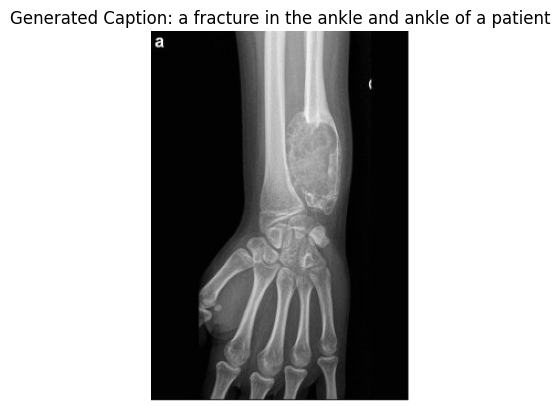

Generating caption for image: ../Datasets/Paper Samples/Samples/Images/sample2.jpg


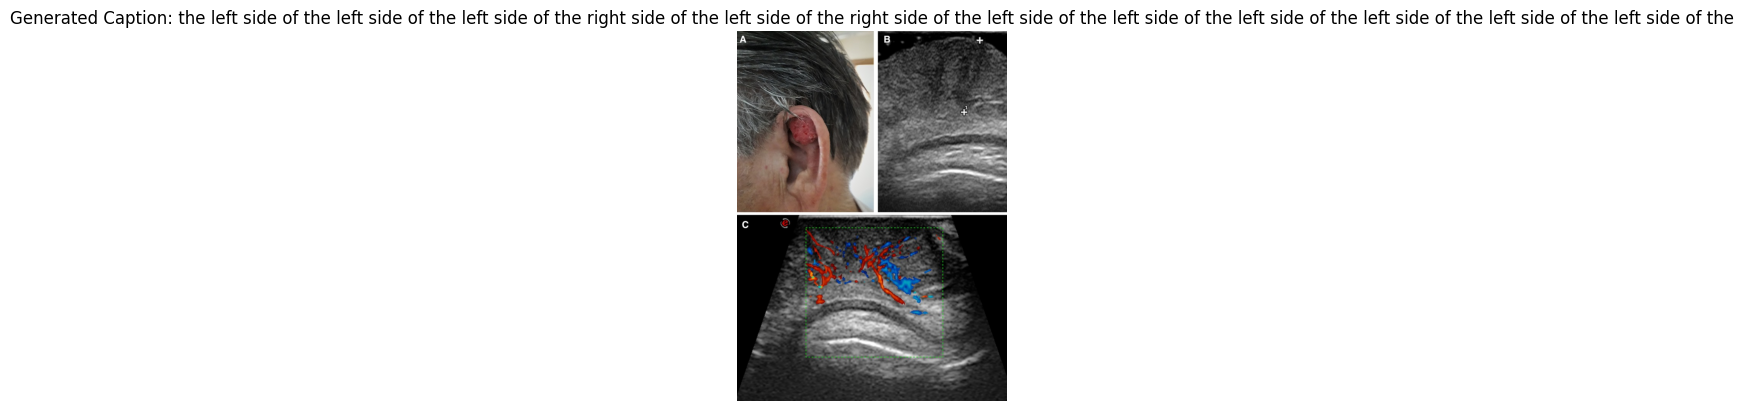

Generating caption for image: ../Datasets/Paper Samples/Samples/Images/sample3.jpg


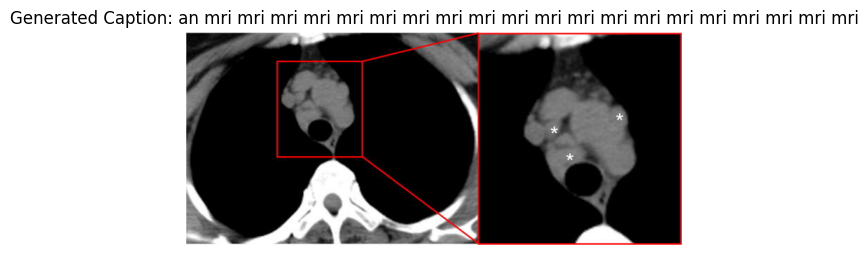

Generating caption for image: ../Datasets/Paper Samples/Samples/Images/sample4.jpg


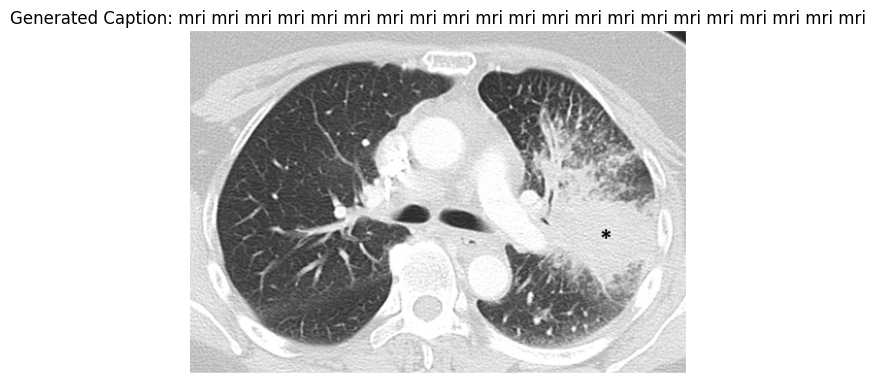

Generating caption for image: ../Datasets/Paper Samples/Samples/Images/sample5.jpg


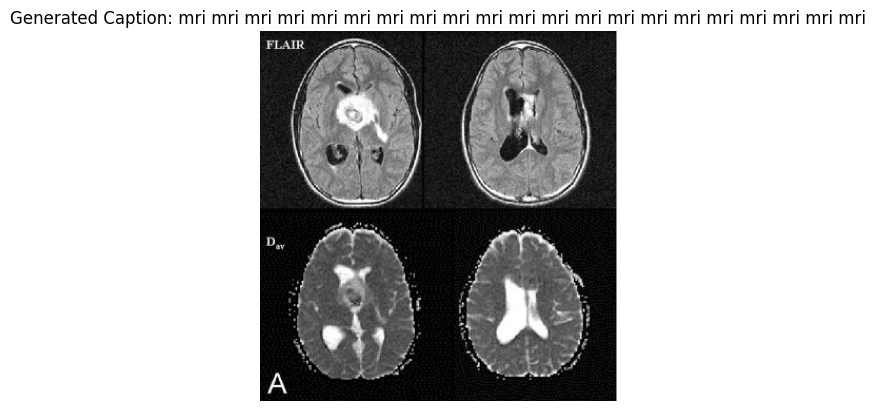

Generating caption for image: ../Datasets/Paper Samples/Samples/Images/sample6.jpg


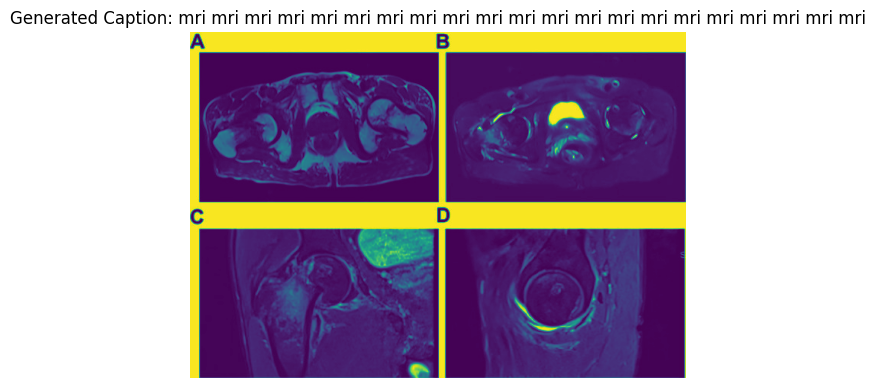

Generating caption for image: ../Datasets/Paper Samples/Samples/Images/sample7.jpg


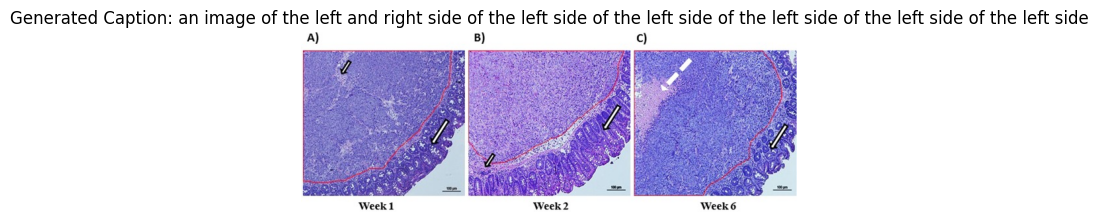

Generating caption for image: ../Datasets/Paper Samples/Samples/Images/sample8.jpg


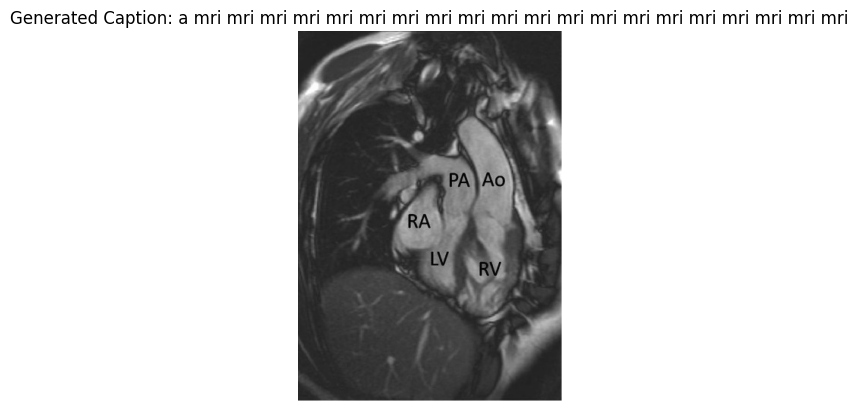

Generating caption for image: ../Datasets/Paper Samples/Samples/Images/sample9.jpg


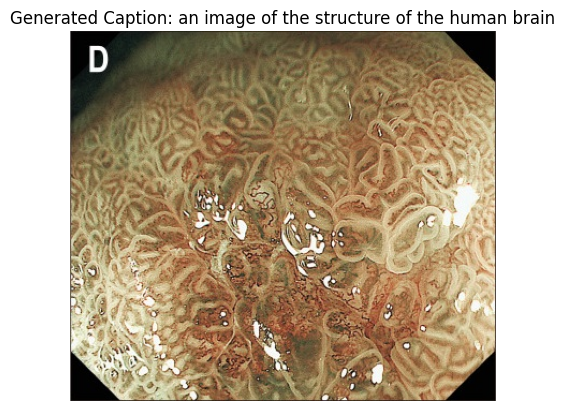

Generating caption for image: ../Datasets/Paper Samples/Samples/Images/sample10.jpg


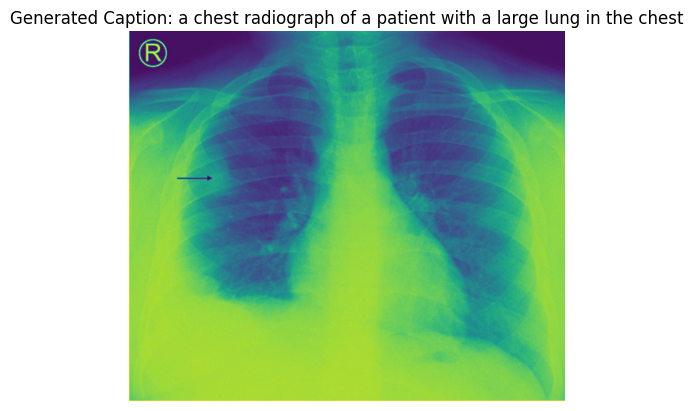

In [9]:
if __name__ == "__main__":
    main(load_existing_model=True)